# Basic data preprocessing 
### load raw files -> generate clips -> compute features-> aggregate into a matrix of features and scores
** Pandas version required to load pickle files is 0.20.1 or greater **

* Try classifying symptom presence from "typing", "walking" and "finger-to-nose" 

In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import time
import nolds
import re
import copy

from PreprocessFcns import *

%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.22.0'

In [11]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
#         dict_path = 'D:\CIS-PD Study\Data_dict'
        dict_path = r'C:\Users\andre\Documents\Data_dict_debug'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path


# #---------------------------------------------------------------------------------------------------------
# # Set path to folder containing Subject ID numbers
# # path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'D:\CIS-PD Study\Subjects' #Windows remote path
# #---------------------------------------------------------------------------------------------------------
# folder_path = r'D:\CIS-PD Study' #generic Windows repo path

# #Path where dictionary subject data is stored
# #dict_path = 'D:\CIS-PD Study\Data_dict_noErr' #remote repo
# dict_path = 'D:\CIS-PD Study\Data_dict'
# # dict_path = '../Data_dict' # Mac local path
# # dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'D:\CIS-PD Study\Scores' #remote repo
# # scores_path = '../Scores/' # Mac local path

# #path where feature matrix is saved
# features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
# # features_path = '../FeatureMatrix' # Mac local path
# # features_path = r'C:\Users\adai\Documents\FeatureMatrix' #Windows local path adai

In [119]:
complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting', 'Unstructured'])

complete_temp = complete
complete_temp.remove('MDS-UPDRS #11: Rest Tremor')


def process_annotations(path):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    del df['Value']
    
    df = df[(df.EventType != 'Testing Day')]
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    return df

## Helper fcns

In [120]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#         sepFlag - 1 if want to reduce unimodal tasks' (finger to nose, pronation-supination, etc.) data in act_dict to
#                   only include active periods i.e right hand sensor excludes data when left hand is performing task
#                   Default value = 0, include all data for unimodal tasks
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    timestamps = process_annotations(path)
    timestamps = fix_errors(SubID, timestamps)
    timestamps = add_unstruct_data(timestamps)
    
    reverse_sensors_1024 = list(['anterior_thigh_left', 'anterior_thigh_right',
                                 'distal_lateral_shank_left', 'distal_lateral_shank_right'])
    # Hard coded list of sensors needed to be reversed in X- and Y- accel/gyro Day 1 data for Subject 1024
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
#     # Temporary fix for missing activities, added 10/10/2017 will remove once error functions are finished
#     if SubID in ('1024', '1030', '1032'):
#         complete_acts = complete_temp
#     else:
#         complete_acts = complete

    complete_acts = complete
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, np.size(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, np.size(startTimestamp)):

            if np.size(startSize) == 1:
                startTime = startTimestamp
                endTime = endTimestamp
            else:
                startTime = startTimestamp[trials]
                endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (np.size(startTimestamp)-1):
                        data['accel'].loc[:, ('Accel X (g)')] = -1*data['accel'].loc[:, ('Accel X (g)')]
                        data['accel'].loc[:, ('Accel Y (g)')] = -1*data['accel'].loc[:, ('Accel Y (g)')]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (np.size(startTimestamp)-1):
                        data['gyro'].loc[:, ('Gyro X (°/s)')] = -1*data['gyro'].loc[:, ('Gyro X (°/s)')]
                        data['gyro'].loc[:, ('Gyro Y (°/s)')] = -1*data['gyro'].loc[:, ('Gyro Y (°/s)')]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps


                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot(figsize=(6,4))
    
    
def gen_unimodal_data(input_dict, side, unimodal_acts=None, shift=50):
#---------------------------------------------------------------------------------------------------------
# Reduces certain activities and subgroup of sensors in act_dict to only include data during active periods
# i.e right hand sensor excludes data when left hand is performing task (e.g. supination-pronation)
#
# Inputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                    accelerometer + gyroscope or accelerometer + EMG/ECG data
#         unimodal_acts - list of tasks to consider for data reduction, default value is None and uses list generated within
#                         function that cycles through all unimodal tasks. Can feed list to only look at specific subset
#         shift - shifting value of starting and ending index of reduced data. Default value is 50
#
# Outputs: act_dict - returns dictionary with appropriate tasks and sensors limited in scope to active data
    
    output_dict = copy.deepcopy(input_dict)
    
    if unimodal_acts and unimodal_acts is not list:
        
        raise Error("unimodal_acts must be of type list")
        
    elif not unimodal_acts:
        unimodal_acts = list(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'])
      
    for acts in unimodal_acts:

        for trials in range(0, len(input_dict[acts].keys())):
            
            for sensors in input_dict[acts][trials].keys():
                
                for data in input_dict[acts][trials][sensors].keys():

                    index = len(input_dict[acts][trials][sensors][data]);
                    
                    if side == 'right':
                    
                        temp_data = input_dict[acts][trials][sensors][data][shift:((index//2)-shift)];
                        output_dict[acts][trials][sensors][data] = temp_data;
                    
                    elif side == 'left':
                    
                        temp_data = input_dict[acts][trials][sensors][data][((index//2)+shift):(index-shift)];
                        output_dict[acts][trials][sensors][data] = temp_data;
                    
    return output_dict


def add_unstruct_data(input_timestamp):
    
    timestamps = input_timestamp.loc[input_timestamp.index != 'Heart Rate Variability']
    
    startTime = []; endTime = []; Cycle = []; Event = [];

    for num in range(1,6):
        startTime.append(timestamps[timestamps['Cycle']==num]['Stop Timestamp (ms)'].iat[-1])
        endTime.append(timestamps[timestamps['Cycle']==(num+1)]['Start Timestamp (ms)'].iat[0])
        Cycle.append(num)
        Event.append('Unstructured')

    d = {'EventType': Event,
         'Start Timestamp (ms)': startTime,
         'Stop Timestamp (ms)': endTime,
         'Cycle': Cycle}

    unstruct = pd.DataFrame(data=d, columns=['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle'])
    unstruct = unstruct.set_index('EventType')
    
    unstructured_timestamps = input_timestamp.append(unstruct)
    
    return unstructured_timestamps

# Fix Error Functions

In [121]:
def fix_errors(participant, timestamps):
#input: 4 digit participant ID
# if debugFlag = 1, will execute merge function
#Output: ErrorList - A list of the errors needed to be fixed for the participant
#        timestamps - The dataFrame with the errors corrected for the participant
#        errordf - The dataFrame containing the remaining errors less the ones just fixed

    participant = int(participant) #convert to int, input SubID is a str
    errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
    errPar = errordf[errordf['Participant'] == participant]
    errorActivity = (errPar['Activity'])
    error = errPar['Error']
    cycle = errPar['Cycle']
    day = errPar['Day']
    time = errPar['Time Adjusted (sec)']
    desc = errPar['Type']
    errorAndActivity = errPar[['Error','Activity']]
    
    # Hard coded relabel for one activity in Subject 1049's timestamps
    if participant == 1049:
        for i in range(0,len(timestamps)-1):
            row = timestamps.iloc[i]
        
            if timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair' and row['Start Timestamp (ms)'] == 1505757980933:
                timestamps.reset_index(inplace=True)
                #timestamps.set_value(i, 'EventType', 'Motor #6: Sit to Stand')
                #.set_value is deprecated as of pandas 21.0, .at used instead for label-based
                timestamps.at[i, 'EventType'] = 'Motor #6: Sit to Stand'
                timestamps.set_index('EventType', inplace=True)
    
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        if errDay == 'Day 2':
            if 'MDS' in errAct:
                errCycle = errCycle + 2
            elif 'Motor' in errAct:
                errCycle = errCycle + 5

        if errType == 'Merge':
#             if debugFlag == 1:
#                 timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
#             else:
#                 ; # do nothing
            timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Late':
            timestamps = fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Early':
            timestamps = fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Duplicate':
            timestamps = fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant)

        elif errType == 'Split':
            timestamps = fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        
        if errType == 'Absent':
            timestamps = fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
    
    
    tempappend = errordf.loc[errPar.index.values]
    #fixdf = fixdf.append(tempappend)
    errordf = errordf.drop(errPar.index.values)
    
    print('Subject ' + str(participant) + ' had ' + str(len(error)) + ' errors fixed.')

    return timestamps


def fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# subtracts time from the beginning or ending timestamp of the designated activity

    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
      
            if errType == 'End':
                startTime = startRow['Stop Timestamp (ms)']
                startTime = startTime - (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
        
            else:
                startTime = startRow['Start Timestamp (ms)']
                # print(startRow)
                # print(startTime)
                startTime = startTime - (errTime*1000)
                # print(errTime)
                # print(startTime)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
     
    return timestamps


def fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# adds time to the beginning or ending timestamp of the designated activity
    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
            
            if errType == 'End':
                startTime = startRow[1]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

            else:
                startTime = startRow[0]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

    return timestamps


def fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-2):
        nextRow = timestamps.iloc[i+1]
        startRow = timestamps.iloc[i]

        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            timeEnd = nextRow['Stop Timestamp (ms)']
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd,takeable=True)
            timestamps.iat[i,ii] = timeEnd
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            timestamps = pd.concat([timestamps.iloc[:(i+1)],timestamps.iloc[(i+2):]])

        timestamps.reset_index(inplace=True)
        timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
        timestamps.set_index('EventType',inplace=True)

    return timestamps

                

def fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timeStart1 = row['Start Timestamp (ms)']
            timeEnd2 = row['Stop Timestamp (ms)']
            timeChange = errTime
            timeEnd1 = timeStart1 + timeChange
            timeStart2 = timeEnd1
            idx = complete.index(errAct)
            ErrorActivity2 = complete[idx+1]
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd1,takeable=True)
            timestamps.iat[i,ii] = timeEnd1
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            line = pd.DataFrame({"Start Timestamp (ms)":timeEnd1,"Stop Timestamp (ms)":timeEnd2,"Cycle":errCycle},index=[ErrorActivity2])
            timestamps = pd.concat([timestamps.iloc[:(i+1)],line,timestamps.iloc[(i+1):]])
            
            timestamps.reset_index(inplace=True)
            colnames = timestamps.columns.tolist()
            colnames[colnames.index('index')] = 'EventType'
            timestamps.columns = colnames
            timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
            timestamps.set_index('EventType',inplace=True)
           
    return timestamps

            

def fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant):

    for i in range(0,len(timestamps)-2):
        row = timestamps.iloc[i]
        if participant == 1054 and timestamps.index[i] == 'Motor #8: Typing on a Computer':
            if timestamps.index[i] == errAct and row['Cycle'] == errCycle+1:
                timestamps = pd.concat([timestamps.iloc[:(i)],timestamps.iloc[(i+1):]])
            
        elif timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])
            
    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

def fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:

            for j in range(i-1,len(timestamps)-1):
                row = timestamps.iloc[j]
                
                if timestamps.index[j] == errAct:
                    cyclenum = row['Cycle']
                    newCycle = cyclenum + 1
                    ii = timestamps.columns.get_loc('Cycle')
                    # timestamps.set_value(j,ii,newCycle,takeable=True)
                    timestamps.iat[j,ii] = newCycle
                    # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
    
    return timestamps

In [15]:
errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
errordf.head()

,Participant,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
0,1004,MDS-UPDRS #9: Postural Hand Tremor,1.0,Split,Day 1,5.0,NaN
1,1004,MDS-UPDRS #10: Kinetic Hand Tremor,1.0,Split Into,Day 1,NaN,NaN
2,1004,Motor #4: Finger to Nose,1.0,Merge,Day 1,NaN,NaN
3,1004,Motor #4: Finger to Nose,2.0,Merge,Day 1,NaN,NaN
4,1004,MDS-UPDRS #6: Arising from Chair,2.0,Absent,Day 1,NaN,Not tested


## Create dictionaries from sensor data from all the subjects

In [16]:
#os.listdir(dict_path)
os.listdir(dict_path)

[]

In [30]:
list(['1046', '1054'])

['1046', '1054']

In [31]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd] #ignore FX at end
print(list(set(f) - set(fd)))

#errors temporarily resolved 10/10/2017, will update later
# f.remove('1030')
# f.remove('1032')
# f.remove('1024')
# f.remove('1052')

['1004', '1016', '1018', '1019', '1020', '1024', '1029', '1030', '1032', '1038', '1044', '1046', '1047', '1049', '1051', '1052', '1053', '1054', '1055', '1056']
['1018', '1055', '1054', '1030', '1019', '1020', '1051', '1056', '1004', '1046', '1047', '1044', '1024', '1052', '1029', '1038', '1049', '1053', '1032', '1016']


In [33]:
#create data dict for remaining subjects
data_all = []
for SubID in list(['1046', '1054']):
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    #save dict to Pickle file
    #filename = dict_path+'\\'+SubID + 'dict.pkl'
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    print(filename)
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print(filename + ' ' + 'File Saved\n')

Loading Subject 1046 Data...
Subject 1046 had 8 errors fixed.
Extract data complete.
C:\Users\andre\Documents\Data_dict_debug\1046dict.pkl
C:\Users\andre\Documents\Data_dict_debug\1046dict.pkl File Saved

Loading Subject 1054 Data...
Subject 1054 had 12 errors fixed.
Extract data complete.
C:\Users\andre\Documents\Data_dict_debug\1054dict.pkl
C:\Users\andre\Documents\Data_dict_debug\1054dict.pkl File Saved



## Explore features from individual subject 

In [122]:
# 1004 Merge Data
SubID = '1046'
debugPath = os.path.join(path, SubID)
act_dict, timestamp = extract_data(int(SubID), debugPath)

Subject 1046 had 8 errors fixed.


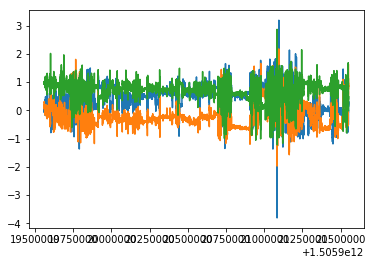

In [130]:
data = act_dict['Unstructured'][0]['dorsal_hand_right']['accel']
plt.plot(data)

In [117]:
timestamp.loc['Unstructured']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Unstructured,1505919560752,1505921552349,1
Unstructured,1505923709726,1505923822353,2
Unstructured,1507134802815,1505925743642,3
Unstructured,1505926333707,1505926996375,4
Unstructured,1505927612712,1505927725882,5


In [118]:
timestamp[timestamp['Cycle'] == 1]

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Heart Rate Variability,1505917619024,1505917979028,1
MDS-UPDRS #1: Finger Tapping,1505918379861,1505918392618,1
MDS-UPDRS #2: Hand Movements,1505918395307,1505918402555,1
MDS-UPDRS #3: Pronation-Supination,1505918404684,1505918410921,1
MDS-UPDRS #4: Toe Tapping,1505918413999,1505918423689,1
MDS-UPDRS #5: Leg Agility,1505918426176,1505918432971,1
MDS-UPDRS #6: Arising from Chair,1505918436886,1505918441987,1
MDS-UPDRS #7: Gait,1505918456195,1505918468219,1
MDS-UPDRS #8: Postural Stability,1505918474536,1505918488886,1


In [82]:
timestamps.loc['Motor #13: Sitting']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #13: Sitting,1505919526100,1505919560752,1
Motor #13: Sitting,1505922137678,1505922173800,2
Motor #13: Sitting,1505924371757,1505924404190,3
Motor #13: Sitting,1505926303775,1505926333707,4
Motor #13: Sitting,1505927579276,1505927612712,5
Motor #13: Sitting,1505928210070,1505928242157,6
Motor #13: Sitting,1507135498878,1507135534716,7


In [83]:
timestamps[timestamps['Cycle']==1]['Stop Timestamp (ms)'].tail(1)

EventType
Motor #13: Sitting    1505919560752
Name: Stop Timestamp (ms), dtype: int64

In [84]:
timestamps[timestamps['Cycle']==1]['Stop Timestamp (ms)'].iat[-1]

1505919560752

In [85]:
timestamps[timestamps['Cycle']==2]['Start Timestamp (ms)'].head(1)

EventType
Motor #1: Standing    1505921552349
Name: Start Timestamp (ms), dtype: int64

In [86]:
timestamps[timestamps['Cycle']==2]['Start Timestamp (ms)'].iat[0]

1505921552349

In [87]:
timestamps.loc['Motor #1: Standing']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #1: Standing,1505918718759,1505918751631,1
Motor #1: Standing,1505921552349,1505921587691,2
Motor #1: Standing,1505923822353,1505923854618,3
Motor #1: Standing,1505925743642,1505925778857,4
Motor #1: Standing,1505926996375,1505927036644,5
Motor #1: Standing,1505927725882,1505927757668,6
Motor #1: Standing,1507134931190,1507134967392,7


In [100]:
startTime = []; endTime = []; Cycle = []; Event = [];

for num in range(1,6):
    startTime.append(timestamps[timestamps['Cycle']==num]['Stop Timestamp (ms)'].iat[-1])
    endTime.append(timestamps[timestamps['Cycle']==(num+1)]['Start Timestamp (ms)'].iat[0])
    Cycle.append(num)
    Event.append('Unstructured')
    
d = {'EventType': Event,
     'Start Timestamp (ms)': startTime,
     'Stop Timestamp (ms)': endTime,
     'Cycle': Cycle}

unstruct = pd.DataFrame(data=d, columns=['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle'])
unstruct = unstruct.set_index('EventType')
    

print(startTime)
print(endTime)
print(Cycle)
print(Event)

[1505919560752, 1505923709726, 1507134802815, 1505926333707, 1505927612712]
[1505921552349, 1505923822353, 1505925743642, 1505926996375, 1505927725882]
[1, 2, 3, 4, 5]
['Unstructured', 'Unstructured', 'Unstructured', 'Unstructured', 'Unstructured']


In [108]:
d = {'EventType': Event,
     'Start Timestamp (ms)': startTime,
     'Stop Timestamp (ms)': endTime,
     'Cycle': Cycle}

unstruct = pd.DataFrame(data=d, columns=['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle'])
unstruct = unstruct.set_index('EventType')
unstruct

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Unstructured,1505919560752,1505921552349,1
Unstructured,1505923709726,1505923822353,2
Unstructured,1507134802815,1505925743642,3
Unstructured,1505926333707,1505926996375,4
Unstructured,1505927612712,1505927725882,5


In [111]:
temp = timestamp.append(unstruct)

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Unstructured,1505919560752,1505921552349,1
Unstructured,1505923709726,1505923822353,2
Unstructured,1507134802815,1505925743642,3
Unstructured,1505926333707,1505926996375,4
Unstructured,1505927612712,1505927725882,5


In [96]:
timestamps[timestamps['Cycle'] == 6]

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #1: Standing,1505927725882,1505927757668,6
Motor #2: Walking,1505927774523,1505927810984,6
Motor #3: Walking while Counting,1505927814191,1505927851451,6
Motor #4: Finger to Nose,1505927863763,1505927901830,6
Motor #5: Alternating Hand Movements,1505927906828,1505927941768,6
Motor #6: Sit to Stand,1505927944558,1505927963066,6
Motor #7: Drawing on Paper,1505927968680,1505928002996,6
Motor #8: Typing on a Computer,1505928016560,1505928055135,6
Motor #9: Nuts and Bolts,1505928065268,1505928098703,6


In [15]:
timestamps.loc['Motor #5: Alternating Hand Movements']

,Cycle,Start Timestamp (ms),Stop Timestamp (ms)
EventType,,,
Motor #5: Alternating Hand Movements,1,1.499435e+12,1499435097295
Motor #5: Alternating Hand Movements,2,1.499438e+12,1499437782996
Motor #5: Alternating Hand Movements,3,1.499440e+12,1499440164574
Motor #5: Alternating Hand Movements,4,1.499442e+12,1499442022084
Motor #5: Alternating Hand Movements,5,1.499444e+12,1499443582974
Motor #5: Alternating Hand Movements,6,1.499445e+12,1499445057742
Motor #5: Alternating Hand Movements,7,1.500386e+12,1500386238203


In [16]:
# 1018 Merge Data
SubID2 = '1018'
debugPath2 = os.path.join(path, SubID2)
# act_dict2_noErr, timestamps2_noErr = extract_data(int(SubID2), debugPath2, 0)
act_dict2, timestamps2 = extract_data(int(SubID2), debugPath2)

Subject 1018 had 2 errors fixed.


In [17]:
#timestamps2_noErr.loc['Motor #11: Organizing Folder']

In [18]:
timestamps2.loc['Motor #11: Organizing Folder']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #11: Organizing Folder,1500040514337,1500040564611,1
Motor #11: Organizing Folder,1500043372310,1500043411877,2
Motor #11: Organizing Folder,1500045224071,1500045285376,3
Motor #11: Organizing Folder,1500046707449,1500046754068,4
Motor #11: Organizing Folder,1500048422867,1500048469595,5
Motor #11: Organizing Folder,1500050552822,1500050606825,6
Motor #11: Organizing Folder,1501596937438,1501596981483,7


In [19]:
# 1032 Merge Data
SubID3 = '1049'
debugPath3 = os.path.join(path, SubID3)
# act_dict3_noErr, timestamps3_noErr = extract_data(int(SubID3), debugPath3, 0)
act_dict3, timestamps3 = extract_data(int(SubID3), debugPath3)

Subject 1049 had 8 errors fixed.


In [20]:
timestamps3.head()

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #1: Finger Tapping,1504625987122,1504626012177,1
MDS-UPDRS #2: Hand Movements,1504626015643,1504626030238,1
MDS-UPDRS #3: Pronation-Supination,1504626033659,1504626047506,1
MDS-UPDRS #4: Toe Tapping,1504626051463,1504626069986,1
MDS-UPDRS #5: Leg Agility,1504626076575,1504626091702,1


In [21]:
timestamps3#.loc['Motor #5: Alternating Hand Movements']
SubID3 = '1049'
pd.options.display.max_rows = 999
Path = os.path.join(path, SubID3)
timestamps = process_annotations(Path)
timestamps.head()

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #1: Finger Tapping,1504625987122,1504626012177,1
MDS-UPDRS #2: Hand Movements,1504626015643,1504626030238,1
MDS-UPDRS #3: Pronation-Supination,1504626033659,1504626047506,1
MDS-UPDRS #4: Toe Tapping,1504626051463,1504626069986,1
MDS-UPDRS #5: Leg Agility,1504626076575,1504626091702,1


In [22]:
# 1046 Merge Data
SubID4 = '1046'
debugPath4 = os.path.join(path, SubID4)
# act_dict4_noErr, timestamps4_noErr = extract_data(int(SubID4), debugPath4, 0)
act_dict4, timestamps4 = extract_data(int(SubID4), debugPath4)

Subject 1046 had 8 errors fixed.


In [23]:
#timestamps4_noErr.loc['Motor #5: Alternating Hand Movements']

In [24]:
timestamps4.loc['Motor #5: Alternating Hand Movements']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #5: Alternating Hand Movements,1505918922988,1505918964452,1
Motor #5: Alternating Hand Movements,1505921739358,1505921776398,2
Motor #5: Alternating Hand Movements,1505924030217,1505924075245,3
Motor #5: Alternating Hand Movements,1505925945489,1505925979799,4
Motor #5: Alternating Hand Movements,1505927181527,1505927218828,5
Motor #5: Alternating Hand Movements,1505927906828,1505927941768,6
Motor #5: Alternating Hand Movements,1507135126633,1507135163595,7


In [25]:
# 1038 Merge Data
SubID5 = '1038'
debugPath5 = os.path.join(path, SubID5)
# act_dict5_noErr, timestamps5_noErr = extract_data(int(SubID5), debugPath5, 0)
act_dict5, timestamps5 = extract_data(int(SubID5), debugPath5)

Subject 1038 had 4 errors fixed.


In [26]:
#timestamps5_noErr.loc['Motor #12: Folding Towels']

In [27]:
timestamps5.loc['Motor #12: Folding Towels']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #12: Folding Towels,1501788809473,1501788870160,1
Motor #12: Folding Towels,1501790688039,1501790739727,2
Motor #12: Folding Towels,1501792408156,1501792459823,3
Motor #12: Folding Towels,1501793985396,1501794038377,4
Motor #12: Folding Towels,1501794890165,1501794956035,5
Motor #12: Folding Towels,1501795716832,1501795754924,6
Motor #12: Folding Towels,1507743777459,1507743848625,7


In [28]:
act_dict['Motor #1: Standing'][0]['anterior_thigh_left']['gyro'].loc[:, ('Gyro X (°/s)')].head()

KeyError: 'Motor #1: Standing'

In [ ]:
-1*act_dict['Motor #1: Standing'][0]['anterior_thigh_left']['gyro'].loc[:, ('Gyro X (°/s)')].head()

In [ ]:
#load Pickle file dict
subj = 1004
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

In [ ]:
#choose task, trials(visits) and sensor location
# task = 'Motor #8: Typing on a Computer'
task = 'Motor #5: Alternating Hand Movements'

loc = 'dorsal_hand_left'
# loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
sensor = 'accel'
trial = 0

In [ ]:
len(act_dict[task].keys())

In [ ]:
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot(figsize=(8,4))

## HP Filter raw accelerometer data

In [ ]:
loc = 'dorsal_hand_left'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

In [ ]:
loc = 'dorsal_hand_right'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

## BP filter (3-8 Hz) for tremor detection

In [ ]:
loc = 'dorsal_hand_left'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

In [ ]:
loc = 'dorsal_hand_right'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])